# EEG: Fp1 - Recursive SARIMA with IHS Transformation
(Left Frontopolar Cloth Surface Electrode on the Forehead)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Analysis-and-Transformation" data-toc-modified-id="Analysis-and-Transformation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis and Transformation</a></span></li><li><span><a href="#Hyper-Parameters-Search" data-toc-modified-id="Hyper-Parameters-Search-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hyper Parameters Search</a></span></li><li><span><a href="#Training-and-Validation" data-toc-modified-id="Training-and-Validation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training and Validation</a></span><ul class="toc-item"><li><span><a href="#Distributions-of-Validation-Errors" data-toc-modified-id="Distributions-of-Validation-Errors-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Distributions of Validation Errors</a></span></li><li><span><a href="#Visualization-of-Validation-Predictions" data-toc-modified-id="Visualization-of-Validation-Predictions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visualization of Validation Predictions</a></span></li></ul></li><li><span><a href="#Test-Predictions" data-toc-modified-id="Test-Predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Test Predictions</a></span></li></ul></div>

## Initialization

In [1]:
# !pip install --use-feature=in-tree-build psutil requests pmdarima nb_black

In [2]:
# !pip install --use-feature=in-tree-build ../pytorch-fit/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/pytorch-fit

In [3]:
# !pip install --use-feature=in-tree-build ../timeseries/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/timeseries

In [4]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%aimport timeseries

<IPython.core.display.Javascript object>

In [5]:
import os
import sys
import time
import IPython.display
from pprint import pprint
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

import timeseries as tss
from timeseries import plot_ts
from timeseries.analysis import acf, pacf, plot_hist, plot_acf, plot_pacf, plot_stats
from timeseries.transform import IHSTransformer, get_smoothed
from timeseries.forecast.utils import Results
from timeseries.forecast.utils import (
    plot_model_test_prediction,
    plot_ground_truth,
    plot_hist_model_scores,
)
from timeseries.forecast.scorings import get_comparison_scorings
from timeseries.forecast import average_scores
from timeseries.forecast.hyper_params import (
    make_grid,
    grid_search_hyper_params,
    print_hyper_scores,
    sorted_scores,
)
from timeseries.forecast.models import (
    SarimaModel,
    sarima_model_version,
    sarima_model_version_str,
)

from timeseries_data import EEGData

<IPython.core.display.Javascript object>

In [6]:
import nb_black

from notebook_init import notebook_init

notebook_init()

<IPython.core.display.Javascript object>

In [7]:
scorings = get_comparison_scorings()

ts_data = EEGData()
data_type = ts_data.data_type
data_name = ts_data.data_name

val_results = Results(data_type, data_name, "val")
test_results = Results(data_type, data_name, "test")

ts = ts_data.ts
train_intv = ts_data.train_interval
val_intv = ts_data.val_interval
test_intv = ts_data.test_interval
pred_steps = ts_data.pred_steps
pred_jump = ts_data.pred_jump

<IPython.core.display.Javascript object>

## Analysis and Transformation

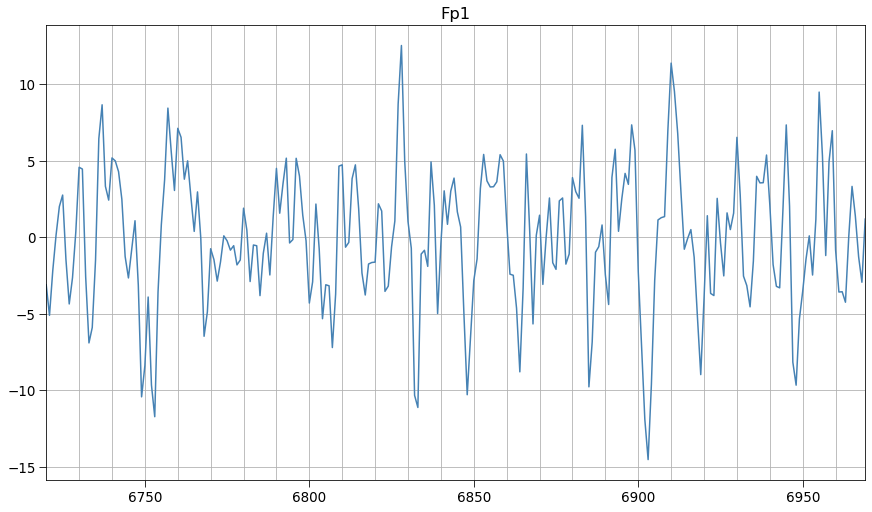

<IPython.core.display.Javascript object>

In [8]:
plot_ts(ts[6720:6970])

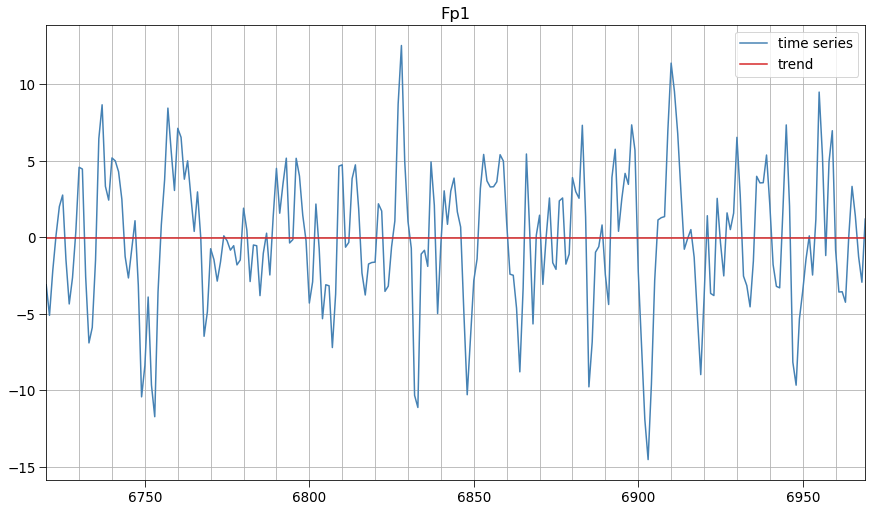

<IPython.core.display.Javascript object>

In [10]:
fig = plot_ts(ts[6720:6970], name="time series")
trend = ts[6720:6970]
trend[:] = np.mean(trend)
plot_ts(trend, fig=fig, color="tab:red", name="trend")

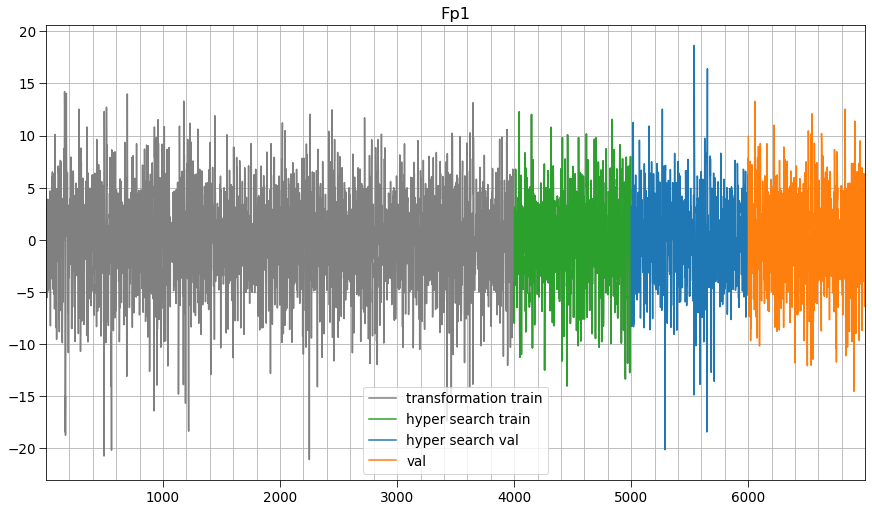

<IPython.core.display.Javascript object>

In [8]:
transformation_train_intv = tss.Interval(ts, 2, 5000)
hyper_search_train_intv = tss.Interval(
    ts, transformation_train_intv.end - 1000, transformation_train_intv.end
)
hyper_search_val_intv = tss.Interval(ts, hyper_search_train_intv.end, val_intv.begin)

fig = plot_ts(
    transformation_train_intv.view(ts), color="grey", name="transformation train"
)
plot_ts(
    hyper_search_train_intv.view(),
    color="tab:green",
    fig=fig,
    name="hyper search train",
)
plot_ts(
    hyper_search_val_intv.view(), color="tab:blue", fig=fig, name="hyper search val"
)
plot_ts(val_intv.view(ts), color="tab:orange", fig=fig, name="val")
display(fig)

Order of differencing: 0


transformation train skewness of ordinary normalized: -0.2659075290206764
hyper-search val skewness of ordinary normalized: -0.1312814610347521


Order of differencing: 0
MLE of IHS lambda: 8.750000e-02


transformation train skewness of normalized with IHS: -0.17486531187895457
hyper-search val skewness of normalized with IHS: -0.07303700546981401


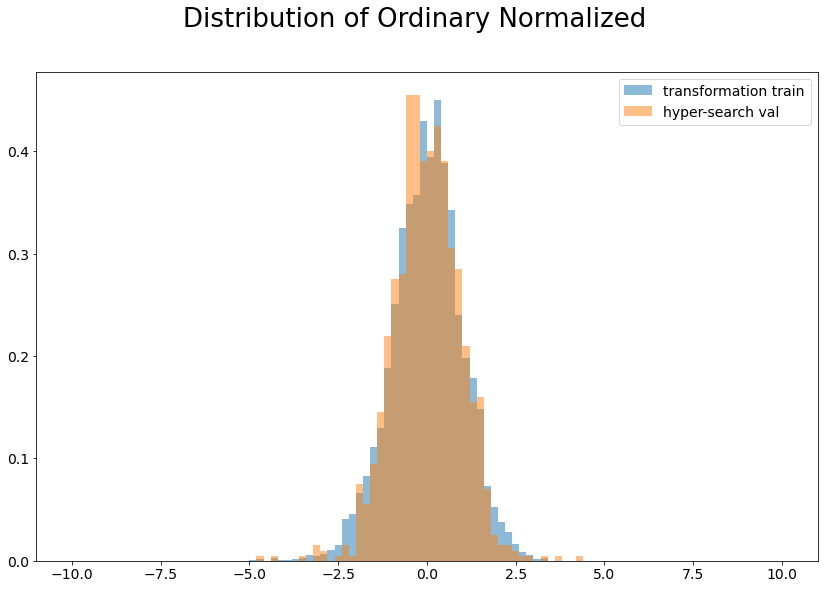

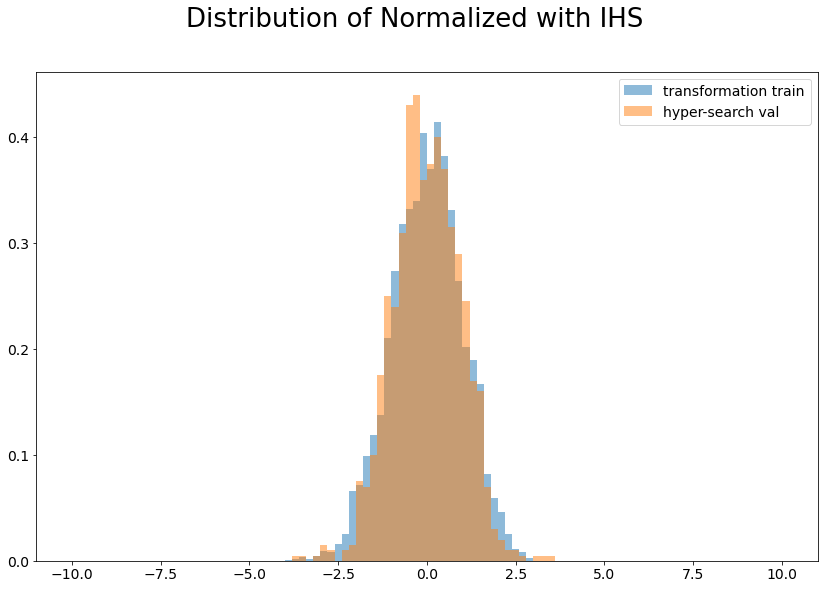

<IPython.core.display.Javascript object>

In [9]:
ordinary_trans = IHSTransformer(
    transformation_train_intv.view(ts), lmb=None, verbose=True
)
ordinary_trans_ts = ordinary_trans.transform(ts)
print(
    f"transformation train skewness of ordinary normalized: {transformation_train_intv.view(ordinary_trans_ts).skew()}"
)
print(
    f"hyper-search val skewness of ordinary normalized: {hyper_search_val_intv.view(ordinary_trans_ts).skew()}"
)
time.sleep(1)

trans = IHSTransformer(transformation_train_intv.view(ts), verbose=True)
trans_ts = trans.transform(ts)
print(
    f"transformation train skewness of normalized with IHS: {transformation_train_intv.view(trans_ts).skew()}"
)
print(
    f"hyper-search val skewness of normalized with IHS: {hyper_search_val_intv.view(trans_ts).skew()}"
)

fig = plot_hist(
    transformation_train_intv.view(ordinary_trans_ts),
    bins=100,
    range=(-10, 10),
    density=True,
    name="transformation train",
    title="Distribution of Ordinary Normalized",
)
display(
    plot_hist(
        hyper_search_val_intv.view(ordinary_trans_ts),
        bins=100,
        range=(-10, 10),
        density=True,
        name="hyper-search val",
        fig=fig,
    )
)

fig = plot_hist(
    transformation_train_intv.view(trans_ts),
    bins=100,
    range=(-10, 10),
    density=True,
    name="transformation train",
    title="Distribution of Normalized with IHS",
)
display(
    plot_hist(
        hyper_search_val_intv.view(trans_ts),
        bins=100,
        range=(-10, 10),
        density=True,
        name="hyper-search val",
        fig=fig,
    )
)


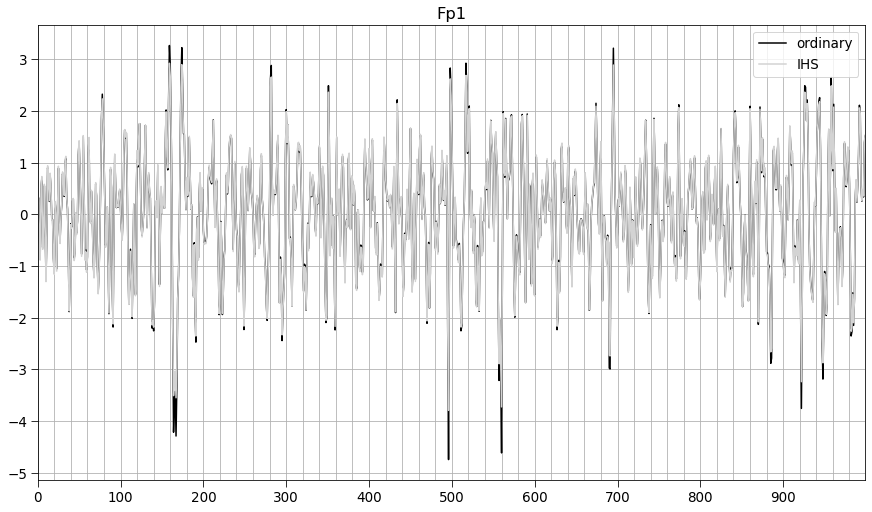

<IPython.core.display.Javascript object>

In [10]:
fig = plot_ts(
    ordinary_trans_ts[:1000],
    name="ordinary",
    color="black",
    alpha=1,
)
plot_ts(
    trans_ts[:1000],
    color="lightgrey",
    name="IHS",
    alpha=1,
    fig=fig,
)
display(fig)

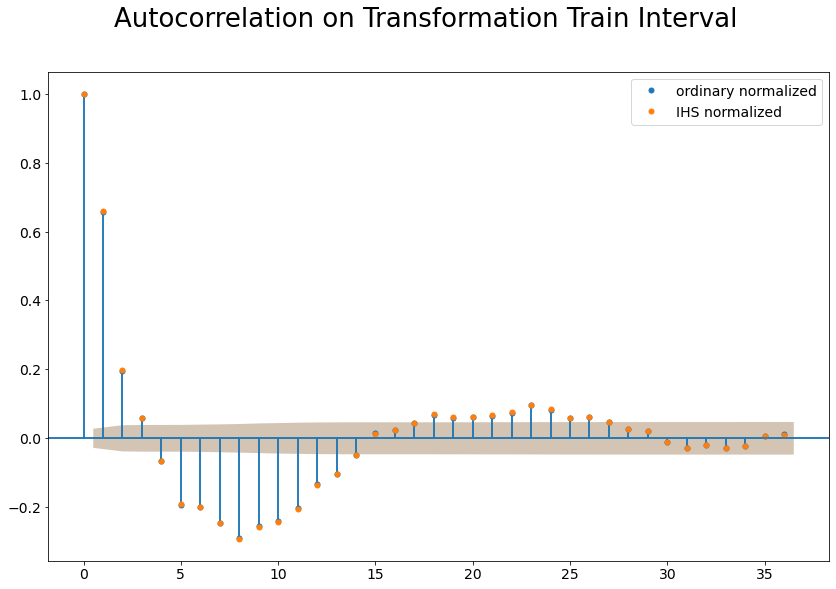

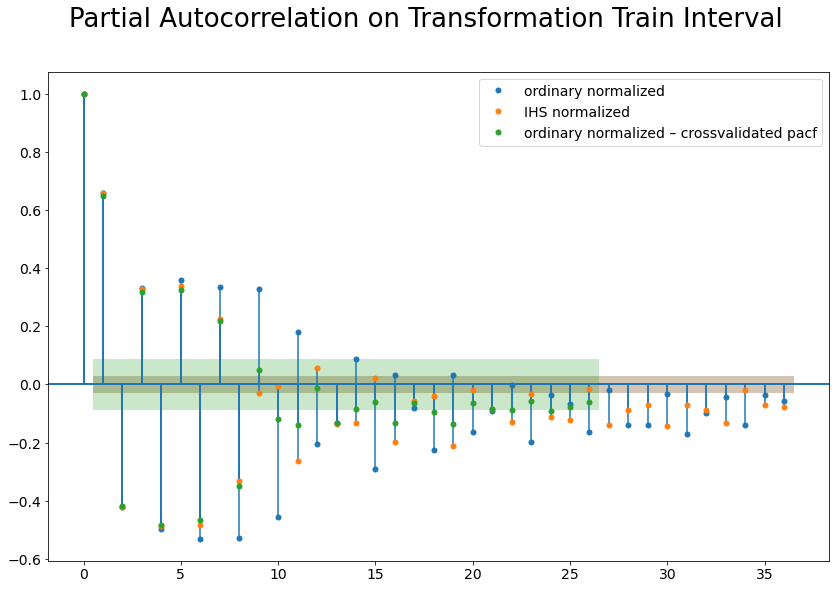

<IPython.core.display.Javascript object>

In [18]:
alpha = 0.05
fig = plot_acf(
    transformation_train_intv.view(ordinary_trans_ts),
    alpha=alpha,
    label="ordinary normalized",
    title="Autocorrelation on Transformation Train Interval",
)
plot_acf(
    transformation_train_intv.view(trans_ts),
    alpha=alpha,
    label="IHS normalized",
    fig=fig,
    width=1030,
    height=700,
)
display(fig)

alpha = 0.05
pacf_method = "yw_mle"
fig = plot_pacf(
    transformation_train_intv.view(ordinary_trans_ts),
    alpha=alpha,
    method=pacf_method,
    label="ordinary normalized",
    title="Partial Autocorrelation on Transformation Train Interval",
)
plot_pacf(
    transformation_train_intv.view(trans_ts),
    alpha=alpha,
    method=pacf_method,
    label="IHS normalized",
    fig=fig,
)
plot_pacf(
    transformation_train_intv.view(ordinary_trans_ts),
    alpha=alpha,
    method=pacf_method,
    cross_validated=True,
    nblocks=20,
    blocks_group=2,
    label="ordinary normalized – crossvalidated pacf",
    fig=fig,
    width=1030,
    height=700,
)
display(fig)

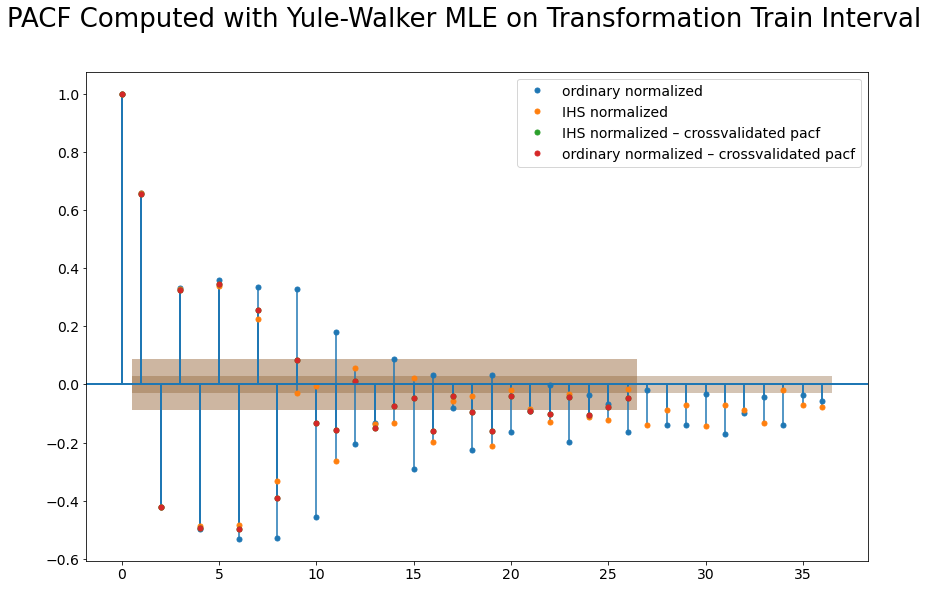

<IPython.core.display.Javascript object>

In [23]:
alpha = 0.05
pacf_method = "yw_mle"
fig = plot_pacf(
    transformation_train_intv.view(ordinary_trans_ts),
    alpha=alpha,
    method=pacf_method,
    label="ordinary normalized",
    title="PACF Computed with Yule-Walker MLE on Transformation Train Interval",
)
plot_pacf(
    transformation_train_intv.view(trans_ts),
    alpha=alpha,
    method=pacf_method,
    label="IHS normalized",
    fig=fig,
)
plot_pacf(
    transformation_train_intv.view(ordinary_trans_ts),
    alpha=alpha,
    method=pacf_method,
    cross_validated=True,
    nblocks=10,
    blocks_group=1,
    label="IHS normalized – crossvalidated pacf",
    fig=fig,
)
plot_pacf(
    transformation_train_intv.view(ordinary_trans_ts),
    alpha=alpha,
    method=pacf_method,
    cross_validated=True,
    nblocks=10,
    blocks_group=1,
    label="ordinary normalized – crossvalidated pacf",
    fig=fig,
    width=1030,
    height=700,
)
display(fig)

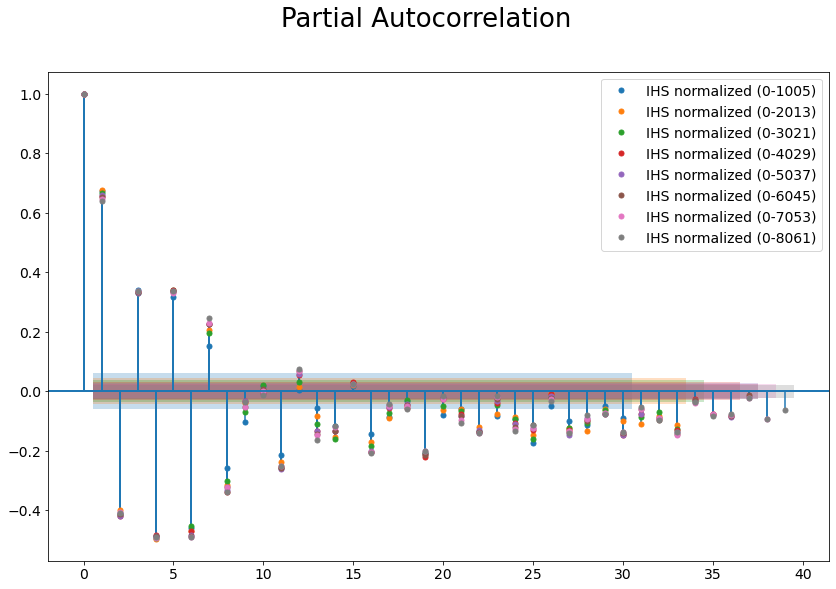

<IPython.core.display.Javascript object>

In [35]:
alpha = 0.05
pacf_method = "yw_mle"
fig = None
n = 8
index = ts.index
for i in range(n):
    begin = transformation_train_intv.begin
    end = index[((i + 1) * len(index)) // n - 1]
    intv = tss.Interval(ts, begin, end)
    fig = plot_pacf(
        intv.view(trans_ts),
        alpha=alpha,
        method=pacf_method,
        label=f"IHS normalized (0-{len(intv.view())})",
        fig=fig,
    )
display(fig)

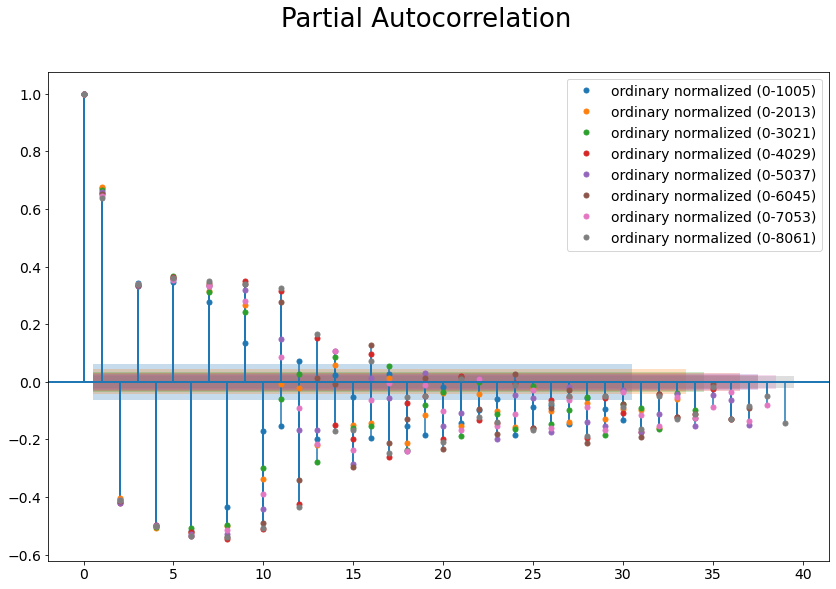

<IPython.core.display.Javascript object>

In [36]:
alpha = 0.05
pacf_method = "yw_mle"
fig = None
n = 8
index = ts.index
for i in range(n):
    begin = transformation_train_intv.begin
    end = index[((i + 1) * len(index)) // n - 1]
    intv = tss.Interval(ts, begin, end)
    fig = plot_pacf(
        intv.view(ordinary_trans_ts),
        alpha=alpha,
        method=pacf_method,
        label=f"ordinary normalized (0-{len(intv.view())})",
        fig=fig,
    )
display(fig)

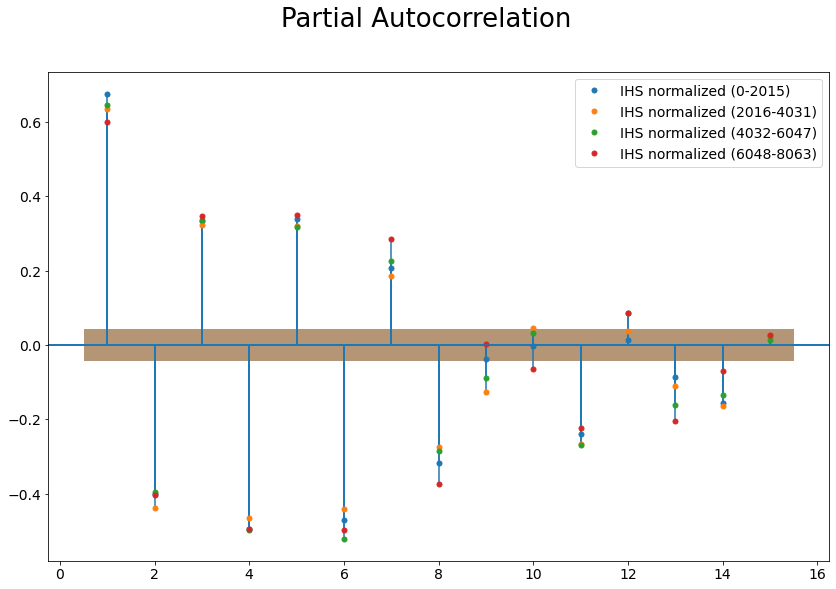

<IPython.core.display.Javascript object>

In [42]:
alpha = 0.05
pacf_method = "yw_mle"
fig = None
n = 4
index = ts.index
for i in range(n):
    begin = index[(i * len(index)) // n]
    end = index[((i + 1) * len(index)) // n - 1]
    intv = tss.Interval(ts, begin, end)
    fig = plot_pacf(
        intv.view(trans_ts),
        alpha=alpha,
        method=pacf_method,
        zero=False,
        nlags=15,
        label=f"IHS normalized ({begin}-{end})",
        fig=fig,
    )
display(fig)

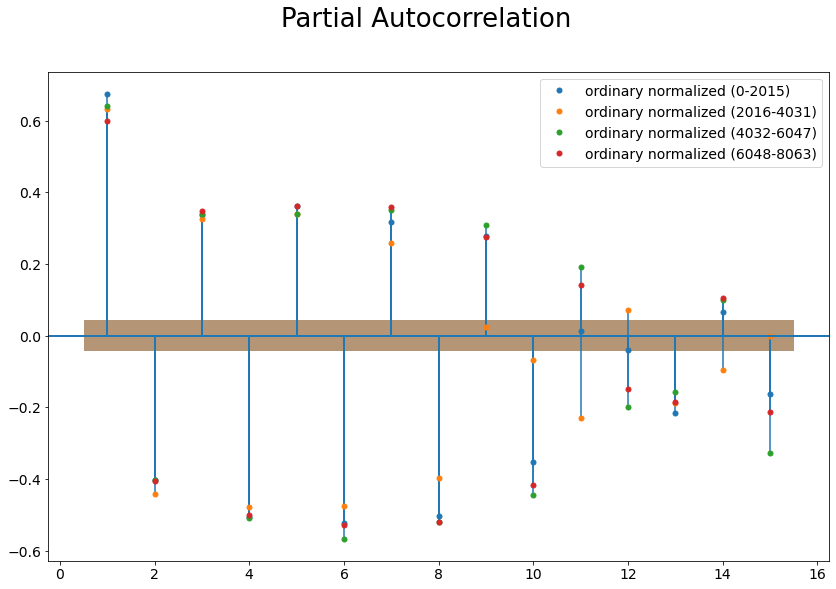

<IPython.core.display.Javascript object>

In [40]:
alpha = 0.05
pacf_method = "yw_mle"
fig = None
n = 4
index = ts.index
for i in range(n):
    begin = index[(i * len(index)) // n]
    end = index[((i + 1) * len(index)) // n - 1]
    intv = tss.Interval(ts, begin, end)
    fig = plot_pacf(
        intv.view(ordinary_trans_ts),
        alpha=alpha,
        method=pacf_method,
        zero=False,
        nlags=15,
        label=f"ordinary normalized ({begin}-{end})",
        fig=fig,
    )
display(fig)

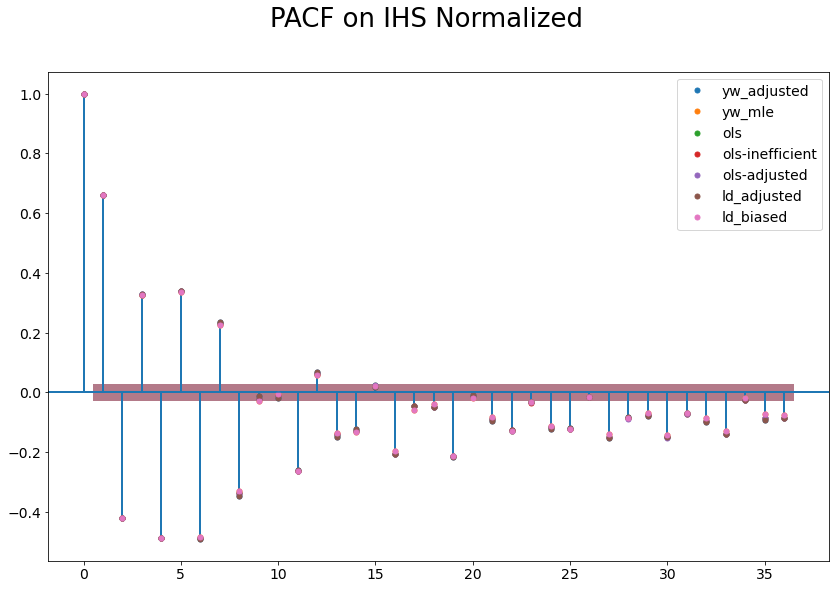

<IPython.core.display.Javascript object>

In [13]:
pacf_methods = [
    "yw_adjusted",
    "yw_mle",
    "ols",
    "ols-inefficient",
    "ols-adjusted",
    "ld_adjusted",
    "ld_biased",
]

fig = None
for pacf_method in pacf_methods:
    fig = plot_pacf(
        transformation_train_intv.view(trans_ts),
        alpha=alpha,
        method=pacf_method,
        label=pacf_method,
        fig=fig,
        title="PACF on IHS Normalized",
    )
display(fig)

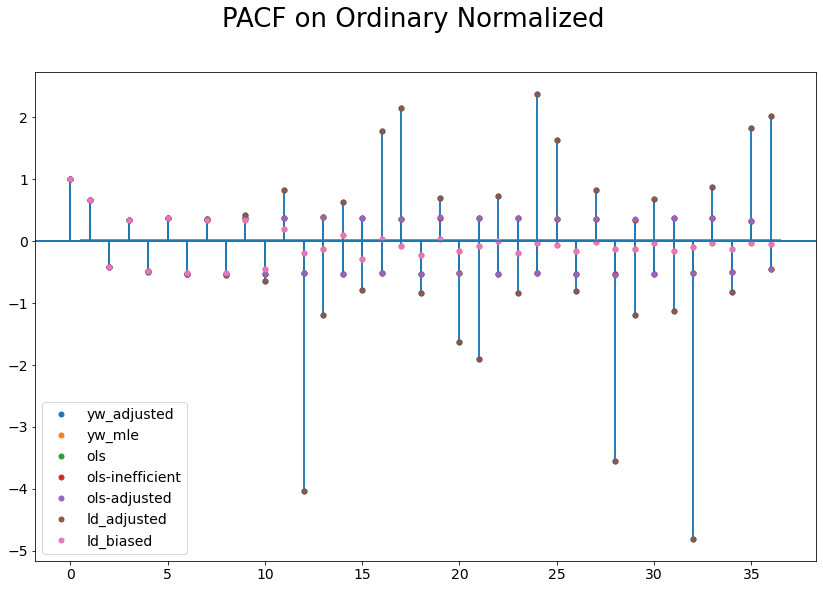

<IPython.core.display.Javascript object>

In [14]:
fig = None
for pacf_method in pacf_methods:
    fig = plot_pacf(
        transformation_train_intv.view(ordinary_trans_ts),
        alpha=alpha,
        method=pacf_method,
        label=pacf_method,
        fig=fig,
        title="PACF on Ordinary Normalized",
    )
display(fig)

In [ ]:
alpha = 0.05
trans_ts_acf, _ = acf(train_intv.view(trans_ts), nlags=70, alpha=alpha)
(trans_ts_acf_idx,) = np.where(np.abs(trans_ts_acf) >= 0.1)

trans_ts_pacf, _ = pacf(
    train_intv.view(trans_ts),
    nlags=70,
    alpha=alpha,
    method="ldbiased",
)
(trans_ts_pacf_idx,) = np.where(np.abs(trans_ts_pacf) >= 0.1)

print(f"acf: {trans_ts_acf_idx}")
print(f"pacf: {trans_ts_pacf_idx}")

## Hyper Parameters Search

In [19]:
def sarima_grid_search(scores=None):
    return grid_search_hyper_params(
        SarimaModel,
        grid,
        trans_ts,
        hyper_search_train_intv,
        hyper_search_val_intv,
        model_params=model_params,
        score_params=score_params,
        fit_params=fit_params,
        best=None,
        scores=scores,
    )

<IPython.core.display.Javascript object>

In [20]:
score_params = dict(
    scorings=["mae"],
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=20,
    mute=True,
)

fit_params = dict(scoring="mae")

<IPython.core.display.Javascript object>

In [21]:
%%time
p_range = [0, 1, 2, 3, 4, 5, 6]
q_range = [0, 1, 2, 3, 4, 5, 6]
grid = make_grid(p=p_range, q=q_range)
grid = [v for v in grid if v["p"] + v["q"] <= 6]

model_params = dict(d=0)

sarima_grid_search_scores = []
sarima_grid_search_scores1 = sarima_grid_search(sarima_grid_search_scores)

the best of all: 3.069 (p=4, q=2)                                                                             


CPU times: user 14min 47s, sys: 11min 49s, total: 26min 37s
Wall time: 27min 28s


<IPython.core.display.Javascript object>

In [23]:
%%time
p_range = [0]
q_range = trans_ts_acf_idx
grid = make_grid(p=p_range, q=q_range)

model_params = dict(d=0)

sarima_grid_search_scores1 = sarima_grid_search(sarima_grid_search_scores)

the best of all: 3.022 (p=0, q=21)                                                                            


CPU times: user 9h 39min 20s, sys: 5h 3min 1s, total: 14h 42min 22s
Wall time: 12h 53min 23s


<IPython.core.display.Javascript object>

In [25]:
%%time
p_range = trans_ts_pacf_idx
q_range = [0]
grid = make_grid(p=p_range, q=q_range)

model_params = dict(d=0)

sarima_grid_search_scores1 = sarima_grid_search(sarima_grid_search_scores)

30/30 (14h 10min 31s), the best of all: 2.919 (p=47, q=0)                                                     


CPU times: user 16h 36min 59s, sys: 9h 34min 37s, total: 1d 2h 11min 37s
Wall time: 14h 10min 32s


<IPython.core.display.Javascript object>

In [32]:
print_hyper_scores(
    sarima_grid_search_scores1[:40], sarima_model_version_str, d=0, suffix=" with IHS"
)

1.   2.919 – ARIMA(47,0,0) with IHS
2.   2.921 – ARIMA(35,0,0) with IHS
3.   2.927 – ARIMA(36,0,0) with IHS
4.   2.931 – ARIMA(44,0,0) with IHS
5.   2.932 – ARIMA(38,0,0) with IHS
6.   2.937 – ARIMA(68,0,0) with IHS
7.   2.938 – ARIMA(41,0,0) with IHS
8.   2.941 – ARIMA(39,0,0) with IHS
9.   2.942 – ARIMA(33,0,0) with IHS
10.  2.955 – ARIMA(59,0,0) with IHS
11.  2.964 – ARIMA(57,0,0) with IHS
12.  2.989 – ARIMA(24,0,0) with IHS
13.  2.995 – ARIMA(29,0,0) with IHS
14.  2.996 – ARIMA(22,0,0) with IHS
15.  2.996 – ARIMA(28,0,0) with IHS
16.  2.997 – ARIMA(27,0,0) with IHS
17.  2.997 – ARIMA(32,0,0) with IHS
18.  2.997 – ARIMA(21,0,0) with IHS
19.  3.000 – ARIMA(25,0,0) with IHS
20.  3.022 – ARIMA(0,0,21) with IHS
21.  3.023 – ARIMA(30,0,0) with IHS
22.  3.027 – ARIMA(19,0,0) with IHS
23.  3.027 – ARIMA(31,0,0) with IHS
24.  3.042 – ARIMA(0,0,19) with IHS
25.  3.049 – ARIMA(0,0,20) with IHS
26.  3.053 – ARIMA(0,0,11) with IHS
27.  3.054 – ARIMA(0,0,18) with IHS
28.  3.055 – ARIMA(0,0,10) w

<IPython.core.display.Javascript object>

In [80]:
chosen_versions = [sarima_grid_search_scores1[i - 1] for i in [2, 20, 30]]
print_hyper_scores(chosen_versions, sarima_model_version_str, d=0, suffix=" with IHS")

1.   2.921 – ARIMA(35,0,0) with IHS
2.   3.022 – ARIMA(0,0,21) with IHS
3.   3.069 – ARIMA(4,0,2) with IHS


<IPython.core.display.Javascript object>

In [58]:
ordinary_res = [
    "2.999 – ARIMA(0,0,11)",
    "3.008 – ARIMA(0,0,18)",
    "3.009 – ARIMA(0,0,10)",
    "3.018 – ARIMA(0,0,8)",
    "3.029 – ARIMA(0,0,9)",
    "3.077 – ARIMA(2,0,2)",
    "3.077 – ARIMA(4,0,2)",
    "3.082 – ARIMA(1,0,4)",
    "3.083 – ARIMA(1,0,5)",
    "3.104 – ARIMA(1,0,3)",
    "3.104 – ARIMA(3,0,2)",
    "3.109 – ARIMA(0,0,7)",
    "3.132 – ARIMA(0,0,6)",
    "3.136 – ARIMA(0,0,5)",
    "3.154 – ARIMA(0,0,4)",
    "3.157 – ARIMA(1,0,2)",
    "3.158 – ARIMA(3,0,3)",
    "3.164 – ARIMA(0,0,3)",
    "3.172 – ARIMA(4,0,0)",
    "3.172 – ARIMA(6,0,0)",
    "3.175 – ARIMA(4,0,1)",
    "3.176 – ARIMA(0,0,2)",
    "3.183 – ARIMA(2,0,3)",
]

ihs_res = [
    "3.053 – ARIMA(0,0,11) with IHS",
    "3.055 – ARIMA(0,0,10) with IHS",
    "3.069 – ARIMA(4,0,2) with IHS",
    "3.079 – ARIMA(0,0,9) with IHS",
    "3.084 – ARIMA(0,0,8) with IHS",
    "3.085 – ARIMA(2,0,2) with IHS",
    "3.092 – ARIMA(0,0,7) with IHS",
    "3.095 – ARIMA(3,0,2) with IHS",
]

for i, (ordinary_res, ihs_res) in enumerate(zip(ordinary_res, ihs_res)):
    print(f"{i+1}. {ordinary_res}  vs.  {ihs_res}")

1. 2.999 – ARIMA(0,0,11)  vs.  3.053 – ARIMA(0,0,11) with IHS
2. 3.008 – ARIMA(0,0,18)  vs.  3.055 – ARIMA(0,0,10) with IHS
3. 3.009 – ARIMA(0,0,10)  vs.  3.069 – ARIMA(4,0,2) with IHS
4. 3.018 – ARIMA(0,0,8)  vs.  3.079 – ARIMA(0,0,9) with IHS
5. 3.029 – ARIMA(0,0,9)  vs.  3.084 – ARIMA(0,0,8) with IHS
6. 3.077 – ARIMA(2,0,2)  vs.  3.085 – ARIMA(2,0,2) with IHS
7. 3.077 – ARIMA(4,0,2)  vs.  3.092 – ARIMA(0,0,7) with IHS
8. 3.082 – ARIMA(1,0,4)  vs.  3.095 – ARIMA(3,0,2) with IHS


<IPython.core.display.Javascript object>

## Training and Validation

In [34]:
%%time
model = SarimaModel(p=51, d=0, q=0, max_ts_len=1200, retrain_ts_len=800)
model.fit(trans_ts, train_intv)

CPU times: user 14min 46s, sys: 4min 39s, total: 19min 26s
Wall time: 14min 24s


<IPython.core.display.Javascript object>

In [38]:
%%time
models_vals = {sarima_model_version_str(val, d=0): dict(val, d=0) for (s, val) in chosen_versions}
models_versions = list(models_vals.keys())
models = {version: SarimaModel(**val) for version, val in models_vals.items()}

val_mean_scores = {}
val_all_scores = {}
val_preds = {}

for i, (model_version, model) in enumerate(models.items()):
    print(f"{i+1}. {model_version}:", file=sys.stderr)
    model.fit(trans_ts, train_intv, scoring="mae")
    val_mean_scores[model_version], val_all_scores[model_version], val_preds[model_version] = average_scores(
        model,
        trans_ts,
        val_intv,
        scorings=scorings,
        trans=trans,
        original_ts=ts,
        n_steps=pred_steps,
        n_steps_jump=pred_jump,
        return_all_scores=True,
        return_preds=True,
    )
    print(f"\n", file=sys.stderr)
time.sleep(1)

1. ARIMA(35,0,0):
139/139 – RMSE: 3.924, MAE: 3.145, MASE: 1.057, sMAPE: 139.0, elapsed time: 2h 40min 53s (last: 1min 11s)      

2. ARIMA(0,0,21):
139/139 – RMSE: 3.885, MAE: 3.125, MASE: 1.046, sMAPE: 162.3, elapsed time: 37min 50s (last: 17.0s)      

3. ARIMA(4,0,2):
139/139 – RMSE: 3.951, MAE: 3.181, MASE: 1.063, sMAPE: 154.7, elapsed time: 10min 57s (last: 7.1s)      



CPU times: user 5h 38s, sys: 2h 44min 14s, total: 7h 44min 52s
Wall time: 3h 35min 51s


<IPython.core.display.Javascript object>

In [42]:
best_versions = [
    model_version
    for _, model_version in sorted_scores(
        [
            (scores["MAE"], model_version)
            for model_version, scores in val_mean_scores.items()
        ]
    )
]

for i, model_version in enumerate(best_versions[:5]):
    model_name, model_version_str = sarima_model_version(models_vals[model_version])
    val_results.set_model(model_name, model_version_str)
    val_results.add_model_scores(val_mean_scores[model_version])
    val_results.add_model_preds(val_preds[model_version])
    mae = val_mean_scores[model_version]["MAE"]
    print(f"{i+1}. {mae:.3f} – {model_version_str}")

1. 3.125 – (0,0,21)
2. 3.145 – (35,0,0)
3. 3.181 – (4,0,2)


<IPython.core.display.Javascript object>

### Distributions of Validation Errors

In [43]:
scoring_name = "MAE"

fig = None
kwargs = dict(engine="plotly")
for model_version in best_versions[:3]:
    fig = plot_hist_model_scores(
        val_all_scores[model_version],
        scoring_name,
        data_name=data_name,
        model_version=model_version,
        in_label=True,
        fig=fig,
        **kwargs
    )
    kwargs = {}
display(fig)

<IPython.core.display.Javascript object>

### Visualization of Validation Predictions

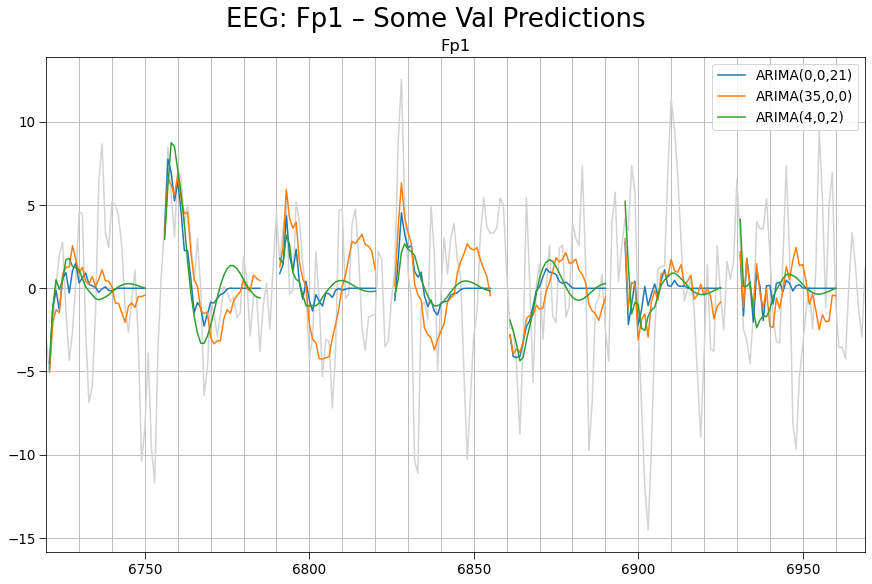

<IPython.core.display.Javascript object>

In [78]:
fig_time_delta = 0
short_val_intv = tss.Interval(ts, 6720, 6970)
fig = plot_ground_truth(
    short_val_intv,
    mode="val",
    data_type=data_type,
    data_name=data_name,
    color="lightgrey",
)
for model_version, color in zip(best_versions[:3], mcolors.TABLEAU_COLORS):
    plot_model_test_prediction(
        short_val_intv,
        fig_time_delta,
        val_preds[model_version],
        model_version=model_version,
        fig=fig,
        color=color,
    )
display(fig)

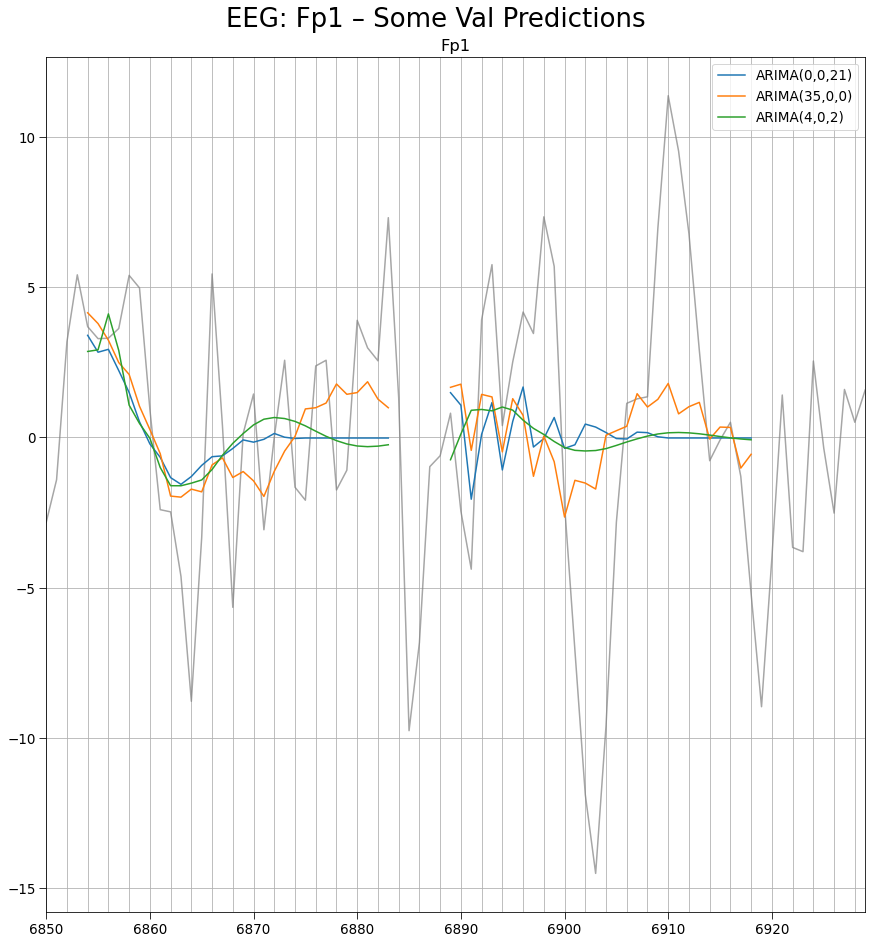

<IPython.core.display.Javascript object>

In [79]:
fig_time_delta = 0
very_short_val_intv = tss.Interval(ts, 6850, 6930)
fig = plot_ground_truth(
    very_short_val_intv,
    mode="val",
    data_type=data_type,
    data_name=data_name,
    color="grey",
    alpha=0.7,
    height=1000,
)
for model_version, color in zip(best_versions[:3], mcolors.TABLEAU_COLORS):
    plot_model_test_prediction(
        very_short_val_intv,
        fig_time_delta,
        val_preds[model_version],
        model_version=model_version,
        fig=fig,
        color=color,
    )
display(fig)

## Test Predictions

In [38]:
%%time
model.update(trans_ts, val_intv)
test_mean_scores, test_all_scores, test_preds = average_scores(
    model,
    trans_ts,
    test_intv,
    trans=trans,
    original_ts=ts,
    scorings=scorings,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(test_mean_scores)
test_results.set_model(model_name, model_version)
test_results.add_model_scores(test_all_scores, test_mean_scores)
test_results.add_model_preds(test_preds)

148/148 – RMSE: 3.53412, MAE: 2.71143, MASE: 0.90923, sMAPE: 119.77098, elapsed time: 3h 32min 47s (last: 51.2s)         
{'MAE': 2.7114261653495233,
 'MASE': 0.9092321425466278,
 'RMSE': 3.5341195756288557,
 'sMAPE': 119.77097721479873}
CPU times: user 5h 36min 58s, sys: 3h 21min 30s, total: 8h 58min 28s
Wall time: 3h 34min 50s


<IPython.core.display.Javascript object>